# Imports

We use the following libraries to fetch and parse html pages, and to interact with the Foursquare API.

In [284]:
from bs4 import BeautifulSoup
import requests
import requests_cache

# Request_cache caches all calls to wikipedia and foursquare so we only have to do it once.
requests_cache.install_cache('requests_cache')

We use regular expressions, e.g. to extract population count and city coordinates from scraped webpages

In [285]:
import re

We use Pandas for building the dataframe.

In [286]:
import pandas as pd

ast to parse a string to a dict

In [287]:
import ast

We use folium for creating maps

In [288]:
import folium
from folium import plugins

We use GeoPandas for working with coordinates

In [339]:
from shapely.geometry import shape, Point
from geopandas import GeoSeries

Matplotlib for graphs and color related functionality

In [342]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

We use NumPy and Scikit-learn for clustering

In [291]:
import math
import numpy as np
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn import metrics

# The Eindhoven neighbourhood datasets

## Obtaining the dataset

Found some datasets on Eindhoven neighbourhoods on https://data.eindhoven.nl/explore/dataset/buurten/export/

In [292]:
# read csv file|
df_ehv = pd.read_csv('buurten.csv', sep=';')

## Cleaning up the neighbourhood dataset

In [293]:
# split latitude and longitude into separate columns
df_ehv[['Latitude', 'Longitude']] = df_ehv['geo_point_2d'].str.split(',', expand=True)
df_ehv[['Latitude', 'Longitude']] = df_ehv[['Latitude', 'Longitude']].apply(lambda x: x.str.strip()).astype(float)

# store the geometric shape
df_ehv['Geo_shape'] = df_ehv['geo_shape'].apply(lambda x: dict(ast.literal_eval(x)))

# drop uninteresting columns
df_ehv.drop(['SHAPE.AREA', 'SHAPE.LEN', 'Objectid ', 'geo_shape', 'geo_point_2d'], axis=1, inplace=True)

# rename change column names
df_ehv.columns = ['Buurtcode', 'Buurtnaam', 'Wijkcode', 'Wijknaam', 'Stadsdeelcode', 'Stadsdeelnaam', 'Latitude', 'Longitude', 'Geo_shape']

df_ehv.head()

Buurtcode    Buurtnaam  Wijkcode             Wijknaam  Stadsdeelcode  \
0        240         Riel        23               Putten              2   
1        632      Meerbos        63            Meerhoven              6   
2        731  Genderbeemd        73  Gestelse Ontginning              7   
3        231     Poeijers        23               Putten              2   
4        512   Prinsejagt        51           Ontginning              5   

   Stadsdeelnaam   Latitude  Longitude  \
0        Stratum  51.416701   5.521553   
1         Strijp  51.450561   5.416852   
2         Gestel  51.422574   5.438449   
3        Stratum  51.431234   5.518226   
4  Woensel-Noord  51.468302   5.458431   

                                           Geo_shape  
0  {'type': 'Polygon', 'coordinates': [[[5.515769...  
1  {'type': 'Polygon', 'coordinates': [[[5.410912...  
2  {'type': 'Polygon', 'coordinates': [[[5.427909...  
3  {'type': 'Polygon', 'coordinates': [[[5.518753...  
4  {'type': 'Polygon', 'coordinates': [[[5.467129...

## Exploring the dataset

We can see from this set how many neighbourhoods (buurten), residential areas (wijken) and boroughs (stadsdeel) the city of Eindhoven has:

In [294]:
print("Eindhoven has {} neighbourhoods (buurt) in {} residential areas (wijk), spread over {} boroughs (stadsdeel)".format(df_ehv.shape[0], len(df_ehv.groupby('Wijkcode')), len(df_ehv.groupby('Stadsdeelcode'))))

Eindhoven has 116 neighbourhoods (buurt) in 20 residential areas (wijk), spread over 7 boroughs (stadsdeel)


From initial exploration we know that Foursquare does not have enough information to do any useful information on Neighbourhood level.

## Putting Eindhoven on the map

To give an initial indication of how the various neighbourhoods look, we plot the shapes from a GeoJSON file containing exactly the same locations as in the table.
Later, we will add more to this map.

In [295]:
# create map of the world using latitude and longitude values
ehv_map = folium.Map(location=[51.4416, 5.4697],zoom_start=12)

fs = plugins.Fullscreen()
ehv_map.add_child(fs)

folium.GeoJson('buurten.geojson.json').add_to(ehv_map)

ehv_map

# Getting key figures

## Obtaining the dataset

Found some datasets on Eindhoven neighbourhoods key figures on [https://opendata.cbs.nl/statline/#/CBS/nl/dataset/84286NED/table?ts=1546775064672]

In [296]:
# read csv file|
df_kern = pd.read_csv('kerncijfers.csv', ";")
df_kern.head()

Wijken en buurten Gemeentenaam Soort regio    Codering  \
0                  Eindhoven    Eindhoven    Gemeente      GM0772   
1  Wijk 11 Stadsdeel Centrum    Eindhoven        Wijk    WK077211   
2                 Binnenstad    Eindhoven       Buurt  BU07721111   
3                     Bergen    Eindhoven       Buurt  BU07721112   
4                 Witte Dame    Eindhoven       Buurt  BU07721113   

   Indelingswijziging wijken en buurten  Inwoners  Inwoners 15 tot 25 jaar  \
0                                   NaN    229126                    31821   
1                                   1.0      8975                     2165   
2                                   1.0      3595                      865   
3                                   1.0      2560                      505   
4                                   1.0      1860                      310   

   Inwoners Westers totaal  Inwoners Nederlandse Antillen en Aruba  \
0                    33209                                    2772   
1                     2220                                      85   
2                      765                                      45   
3                      570                                      15   
4                      535                                      15   

   Eenpersoonshuishoudens  Bevolkingsdichtheid  Woningvoorraad  \
0                   57152               2614.0          109468   
1                    4660               3421.0            5827   
2                    1930               5491.0            2163   
3                    1215               7452.0            1595   
4                     735              10132.0            1468   

   Percentage meergezinswoning  Personenauto's; brandstof benzine  \
0                         38.0                              82010   
1                         93.0                               2200   
2                         91.0                                910   
3                         85.0                                760   
4                        100.0                                460   

   Motorfietsen  Oppervlakte  Mate van stedelijkheid  \
0          6820         8766                     1.0   
1           265          262                     1.0   
2            85           66                     1.0   
3            80           34                     1.0   
4            95           18                     1.0   

   Omgevingsadressendichtheid  
0                      2605.0  
1                      3938.0  
2                      3862.0  
3                      4173.0  
4                      4412.0

## Cleaning up the neighbourhood dataset

In [297]:
# We only want neighbourhoods, not aggregated results
df_kern = df_kern[df_kern["Soort regio"] == "Buurt"]

# Pick some interesting columns
df_kern = df_kern[["Wijken en buurten", "Bevolkingsdichtheid", "Mate van stedelijkheid", "Omgevingsadressendichtheid"]]
df_kern.columns = ["Buurtnaam", "Dichtheid", "Stedelijkheid", "Adresdichtheid"]
df_kern[["Dichtheid", "Stedelijkheid", "Adresdichtheid"]].astype(float)

df_kern.head()

Buurtnaam  Dichtheid  Stedelijkheid  Adresdichtheid
2  Binnenstad     5491.0            1.0          3862.0
3      Bergen     7452.0            1.0          4173.0
4  Witte Dame    10132.0            1.0          4412.0
5  Fellenoord      751.0            1.0          3958.0
6  TU-terrein      648.0            2.0          2051.0

Now let's see if we have any NaN's left to deal with.

In [298]:
df_kern[df_kern.isnull().any(1)]

Buurtnaam  Dichtheid  Stedelijkheid  Adresdichtheid
23            Poeijers        NaN            2.0          1761.0
31        Leenderheide        NaN            NaN             NaN
106       Flight Forum        NaN            5.0           229.0
107  Eindhoven Airport        NaN            5.0            70.0
120            Beemden        NaN            4.0           663.0

These are all industrial aread with no residents, except for Leenderheide which is nature reserve. Let's replace the NaNs with zeroes.

In [299]:
df_kern = df_kern.fillna(0)

## Linking up to the previous data set

In [300]:
df_ehv = pd.merge(df_ehv, df_kern, on="Buurtnaam", validate="1:1")
df_ehv.head()

Buurtcode    Buurtnaam  Wijkcode             Wijknaam  Stadsdeelcode  \
0        240         Riel        23               Putten              2   
1        632      Meerbos        63            Meerhoven              6   
2        731  Genderbeemd        73  Gestelse Ontginning              7   
3        231     Poeijers        23               Putten              2   
4        512   Prinsejagt        51           Ontginning              5   

   Stadsdeelnaam   Latitude  Longitude  \
0        Stratum  51.416701   5.521553   
1         Strijp  51.450561   5.416852   
2         Gestel  51.422574   5.438449   
3        Stratum  51.431234   5.518226   
4  Woensel-Noord  51.468302   5.458431   

                                           Geo_shape  Dichtheid  \
0  {'type': 'Polygon', 'coordinates': [[[5.515769...       99.0   
1  {'type': 'Polygon', 'coordinates': [[[5.410912...       38.0   
2  {'type': 'Polygon', 'coordinates': [[[5.427909...     3673.0   
3  {'type': 'Polygon', 'coordinates': [[[5.518753...        0.0   
4  {'type': 'Polygon', 'coordinates': [[[5.467129...     4882.0   

   Stedelijkheid  Adresdichtheid  
0            4.0           737.0  
1            3.0          1078.0  
2            2.0          1799.0  
3            2.0          1761.0  
4            2.0          2374.0

## Choropleth map of Eindhoven

Let's make a choropleth map of the neighbourhoods based on population density. 
The result clearly show some neighbourhoods with no people living in it. These are two industrial areas, an airport and a park

In [301]:
# create map of the world using latitude and longitude values
ehv_map = folium.Map(location=[51.4416, 5.4697],zoom_start=12)

fs = plugins.Fullscreen()
ehv_map.add_child(fs)

folium.GeoJson('buurten.geojson.json').add_to(ehv_map)

folium.Choropleth(
    geo_data='buurten.geojson.json',
    name='Population Density',
    data=df_ehv,
    columns=['Buurtcode', 'Dichtheid'],
    key_on='feature.properties.buurtcode',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Population Density'
).add_to(ehv_map)

ehv_map

# Getting venue information from Foursquare

In this section we will ask Foursquare for the Top Picks venues in neighbourhood in the city of Eindhoven

## Setting up the connection

The following information is needed to connect with Foursquare API

In [302]:
CLIENT_ID = 'YPBVFDUZOP1M24BKCWGXIYZ3RFACOE3V35WSFY4DSCMRU44L' # your Foursquare ID
CLIENT_SECRET = 'VYHYTBSRIZBPYAOCP5ZEFV3YM4C40YEQCQWCUO4NC1JTPNJM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

## Scraper function

We will ask Foursquare for venues in every neighbourhoods, then store its name, location and main category.

The following function takes series of Cities and their latituted and longitudes. It will then output a dataframe containing all these venues. 

We try to find as many venues as possible within the smallest circle that surrounds the neighbourhood. Not all of those venues will be in the neighbourhood itself, but since they are easily reachable they do count towards the character of those neighbourhoods.

In [360]:
MAX=200
LIMIT=50

def getRecommendedVenues(neighbourhoods, nbcodes, latitudes, longitudes, polygons):
    
    venues_list=[]
    for nb, code, lat, lon, poly in zip(neighbourhoods, nbcodes, latitudes, longitudes, polygons):
         
        # compute radius for neighbourhood    
        gs1 = GeoSeries(Point(lon,lat))
        gs1.crs = {'init': 'epsg:4326'}
        
        gs2 = GeoSeries(shape(poly))
        gs2.crs = {'init': 'epsg:4326'}
        radius = gs1.distance(gs2)
        print("{}: {}".format(nb, radius))
    
        for offset in range(0,MAX,LIMIT):
            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&intent=browse&v={}&ll={},{}&limit={}&offset={}&radius={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat,
                lon,
                LIMIT,
                offset,
                RADIUS)

            # make the GET request
            response = requests.get(url)
            if response.status_code == requests.codes.ok:
                results = response.json()["response"]['venues']
                if len(results)==0:
                    continue
            else:
                print ("status was:" + str(response.status_code))
                print ("could not scrape " + url)
                print (response)
                break
            for v in results:
                if len(v['categories']) != 0:
                    venues_list.append([(
                        code,
                        v['name'], 
                        v['id'],
                        v['location']['lat'], 
                        v['location']['lng'],  
                        v['categories'][0]['name'])])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Buurtcode',
                  'Venue',
                  'Venue ID',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## Scraping from foursquare

Now we can run it on all the cities from our cities dataframe and store the found venues in a new dataframe.
This can take a while when running for the first time, and also fail a few times with a 504 error. 

But every request will be cached, which makes subsequent calls incredibly fast.

In [361]:
df_venues = getRecommendedVenues(df_ehv['Buurtnaam'], df_ehv['Buurtcode'], df_ehv['Latitude'], df_ehv['Longitude'], df_ehv['Geo_shape'])
print ("Found {} venues for {} different neighbourhoods".format(df_venues.shape[0], len(df_venues.groupby('Buurtcode'))))

df_venues_unique = df_venues.drop(['Buurtcode'], axis=1).drop_duplicates()
print ("Found {} unique venues".format(df_venues_unique.shape[0]))

df_venues.head()

Riel: 0    0.0
dtype: float64
Meerbos: 0    0.0
dtype: float64
Genderbeemd: 0    0.0
dtype: float64
Poeijers: 0    0.0
dtype: float64
Prinsejagt: 0    0.0
dtype: float64
Lievendaal: 0    0.0
dtype: float64
Mispelhoef: 0    0.0
dtype: float64
BeA2: 0    0.0
dtype: float64
Hurk: 0    0.0
dtype: float64
Urkhoven: 0    0.0
dtype: float64
Gennep: 0    0.0
dtype: float64
't Hofke: 0    0.0
dtype: float64
Bokt: 0    0.0
dtype: float64
Hanevoet: 0    0.0
dtype: float64
Woensel-West: 0    0.0
dtype: float64
Luytelaer: 0    0.0
dtype: float64
Bennekel-West, Gagelbosch: 0    0.0
dtype: float64
Tuindorp: 0    0.0
dtype: float64
Schoot: 0    0.0
dtype: float64
Bosrijk: 0    0.0
dtype: float64
Eliasterrein, Vonderkwartier: 0    0.0
dtype: float64
Strijp S: 0    0.0
dtype: float64
Kruidenbuurt: 0    0.0
dtype: float64
Sintenbuurt: 0    0.0
dtype: float64
Waterrijk: 0    0.0
dtype: float64
Jagershoef: 0    0.0
dtype: float64
Irisbuurt: 0    0.0
dtype: float64
Kapelbeemd: 0    0.0
dtype: float64
Achtse

Buurtcode                            Venue                  Venue ID  \
0        240               Bunderkensven 1-13  56ea9402cd10fb42d8c16ff8   
1        240            Random Veld Eindhoven  57190012498ebfa7c0bc536b   
2        240  wirowok st wirostraat eindhoven  4e1c6999a80980ebf5a18737   
3        240                  Stratumse Heide  4d135e43f898b1f73f8edf81   
4        240                    Stal De Groof  4db971516e818f67a9be8786   

   Venue Latitude  Venue Longitude                            Venue Category  
0       51.418413         5.515813  Residential Building (Apartment / Condo)  
1       51.415874         5.524489                      Other Great Outdoors  
2       51.416636         5.518441                          Asian Restaurant  
3       51.406006         5.516467                      Other Great Outdoors  
4       51.419093         5.523564                                      Farm

## Putting venues on the map

Putting all venues on a map is a stretch for Jupyter, so it may not actually display.  
Fortunately we can export the map as HTML and open it separately.

In [305]:
# create map of the world using latitude and longitude values
ehv_venues_map = folium.Map(location=[51.4416, 5.4697],zoom_start=12, prefer_canvas=True )

# create a full screen button
fs = plugins.Fullscreen()
ehv_venues_map.add_child(fs)


folium.GeoJson('buurten.geojson.json').add_to(ehv_venues_map)

# add markers to map for every venue
for lat, lng, venue, cat in zip(df_venues_unique['Venue Latitude'], df_venues_unique['Venue Longitude'], df_venues_unique['Venue'], df_venues_unique['Venue Category']):
    label = '{}: {}'.format(venue, cat)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
    ).add_to(ehv_venues_map)  
    
# save the map to interactive html, then display
ehv_venues_map.save('ehv_venues_map.html')
ehv_venues_map

# Clustering neighbourhoods

## Counting venue categories

Just as in the lectures, we want to find out what the types of venues are for each neighbourhood.

We do this by first turning the venue categories in one-hot notations, and then averaging these numbers for every neighbourhood.
This automatically takes care of having different amounts of venues for different neighbourhoods.

In [306]:
# one hot encoding of venue category
df_venues_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add other columns back to the dataframe
df_venues_onehot['Buurtcode'] = df_venues['Buurtcode']

# move those column to the first column
fixed_columns = list(df_venues_onehot.columns[-1:]) + list(df_venues_onehot.columns[:-1])
df_venues_onehot = df_venues_onehot[fixed_columns]

df_venues_onehot.head()

Buurtcode  ATM  Accessories Store  Advertising Agency  Afghan Restaurant  \
0        240    0                  0                   0                  0   
1        240    0                  0                   0                  0   
2        240    0                  0                   0                  0   
3        240    0                  0                   0                  0   
4        240    0                  0                   0                  0   

   African Restaurant  Airport  Airport Gate  Airport Service  \
0                   0        0             0                0   
1                   0        0             0                0   
2                   0        0             0                0   
3                   0        0             0                0   
4                   0        0             0                0   

   Airport Terminal     ...       Waste Facility  Water Park  Whisky Bar  \
0                 0     ...                    0           0           0   
1                 0     ...                    0           0           0   
2                 0     ...                    0           0           0   
3                 0     ...                    0           0           0   
4                 0     ...                    0           0           0   

   Wine Bar  Wine Shop  Winery  Wings Joint  Women's Store  Yoga Studio  \
0         0          0       0            0              0            0   
1         0          0       0            0              0            0   
2         0          0       0            0              0            0   
3         0          0       0            0              0            0   
4         0          0       0            0              0            0   

   Zoo Exhibit  
0            0  
1            0  
2            0  
3            0  
4            0  

[5 rows x 429 columns]

## Most common venue categories per city

In [307]:
df_venues_grouped = df_venues_onehot.groupby(['Buurtcode']).sum().reset_index()

In [308]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [309]:
num_top_venues = 5

# create columns according to number of top venues
columns = ['Buurtcode']
for ind in np.arange(num_top_venues):
    columns.append('Common Venue {}'.format(ind+1))

# create a new dataframe
df_common_venues = pd.DataFrame(columns=columns)
df_common_venues['Buurtcode'] = df_venues_grouped['Buurtcode']

# actually perform counting
for ind in np.arange(df_venues_grouped.shape[0]):
    df_common_venues.iloc[ind, 1:] = return_most_common_venues(df_venues_grouped.iloc[ind, :], num_top_venues)

In [310]:
df_common_venues.head()

Buurtcode      Common Venue 1 Common Venue 2             Common Venue 3  \
0        111      Clothing Store  Women's Store       Fast Food Restaurant   
1        112  Salon / Barbershop    Art Gallery          Electronics Store   
2        113               Hotel          Plaza                     Office   
3        114            Bus Line          Hotel               Neighborhood   
4        115         College Lab            Bar  College Academic Building   

                             Common Venue 4     Common Venue 5  
0                                Restaurant        Men's Store  
1  Residential Building (Apartment / Condo)   Asian Restaurant  
2                              Neighborhood               City  
3                                    Office        Bus Station  
4                                University  College Classroom

## Finding similar neighbourhoods

For clustering, we use the averages for every category as found in section 3, but drop the buurtcode attributes.  
Then, we merge back Density, urbanisation and housing density fields.

In [311]:
# sum the venues types found for each neighbourhood
df_clustering = df_venues_onehot.groupby(['Buurtcode']).sum().reset_index()

# normalize over all columns except the 'Buurtcode' column.
collist = df_clustering.columns.tolist()
collist.remove('Buurtcode')
df_clustering[collist] = df_clustering[collist].div(df_clustering.sum(axis=1), axis=0)

# merge back in additional columns
df_clustering = pd.merge(df_clustering, df_ehv[["Buurtcode", "Dichtheid", "Stedelijkheid", "Adresdichtheid"]], on="Buurtcode")
df_clustering.head()

Buurtcode  ATM  Accessories Store  Advertising Agency  Afghan Restaurant  \
0        111  0.0                0.0                 0.0                0.0   
1        112  0.0                0.0                 0.0                0.0   
2        113  0.0                0.0                 0.0                0.0   
3        114  0.0                0.0                 0.0                0.0   
4        115  0.0                0.0                 0.0                0.0   

   African Restaurant  Airport  Airport Gate  Airport Service  \
0                 0.0      0.0           0.0              0.0   
1                 0.0      0.0           0.0              0.0   
2                 0.0      0.0           0.0              0.0   
3                 0.0      0.0           0.0              0.0   
4                 0.0      0.0           0.0              0.0   

   Airport Terminal       ...        Wine Bar  Wine Shop  Winery  Wings Joint  \
0               0.0       ...             0.0        0.0     0.0          0.0   
1               0.0       ...             0.0        0.0     0.0          0.0   
2               0.0       ...             0.0        0.0     0.0          0.0   
3               0.0       ...             0.0        0.0     0.0          0.0   
4               0.0       ...             0.0        0.0     0.0          0.0   

   Women's Store  Yoga Studio  Zoo Exhibit  Dichtheid  Stedelijkheid  \
0       0.025723          0.0          0.0     5491.0            1.0   
1       0.000000          0.0          0.0     7452.0            1.0   
2       0.000000          0.0          0.0    10132.0            1.0   
3       0.000000          0.0          0.0      751.0            1.0   
4       0.000000          0.0          0.0      648.0            2.0   

   Adresdichtheid  
0          3862.0  
1          4173.0  
2          4412.0  
3          3958.0  
4          2051.0  

[5 rows x 432 columns]

### Finding optimal value for $k$

We look at a silhouette score for various values of k to find an optimal one.

A first look immediately finds that 2,3,4 give better values, but I find that too few clusters.

maximum is 0.45764055545879223, which occurs at k=5


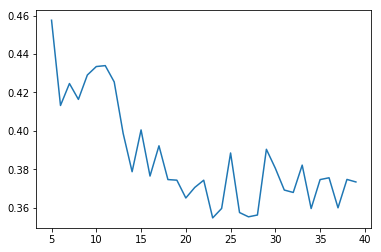

In [312]:
START = 5
END = 40
scores = []
for k in range(START, END):
    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_clustering)
    
    scores.append(metrics.silhouette_score(df_clustering, kmeans.labels_))   
print( "maximum is {}, which occurs at k={}".format(np.max(scores),np.argmax(scores)+START))
kclusters=np.argmax(scores)+START
plt.plot(range(START,END),scores)

### Clustering

We use Scikit-learn for kmeans clustering, with $k=\mathrm{kclusters}$ clusters.

In [313]:
kclusters=11
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clustering)

We add these labels to the cities dataframe, as well as the most common venues found in the previous section.

We save the result as a new dataframe

In [314]:
df_common_venues['Cluster label'] = kmeans.labels_

df_ehv_clusters = pd.merge( df_ehv, df_common_venues, how='left',
        on=['Buurtcode'])
df_ehv_clusters.head()

Buurtcode    Buurtnaam  Wijkcode             Wijknaam  Stadsdeelcode  \
0        240         Riel        23               Putten              2   
1        632      Meerbos        63            Meerhoven              6   
2        731  Genderbeemd        73  Gestelse Ontginning              7   
3        231     Poeijers        23               Putten              2   
4        512   Prinsejagt        51           Ontginning              5   

   Stadsdeelnaam   Latitude  Longitude  \
0        Stratum  51.416701   5.521553   
1         Strijp  51.450561   5.416852   
2         Gestel  51.422574   5.438449   
3        Stratum  51.431234   5.518226   
4  Woensel-Noord  51.468302   5.458431   

                                           Geo_shape  Dichtheid  \
0  {'type': 'Polygon', 'coordinates': [[[5.515769...       99.0   
1  {'type': 'Polygon', 'coordinates': [[[5.410912...       38.0   
2  {'type': 'Polygon', 'coordinates': [[[5.427909...     3673.0   
3  {'type': 'Polygon', 'coordinates': [[[5.518753...        0.0   
4  {'type': 'Polygon', 'coordinates': [[[5.467129...     4882.0   

   Stedelijkheid  Adresdichtheid        Common Venue 1  \
0            4.0           737.0  Other Great Outdoors   
1            3.0          1078.0            Restaurant   
2            2.0          1799.0    Salon / Barbershop   
3            2.0          1761.0               Factory   
4            2.0          2374.0    Salon / Barbershop   

                             Common Venue 2 Common Venue 3   Common Venue 4  \
0                                       Bar       Pharmacy          Dog Run   
1                                  Building    Event Space             City   
2                            Medical Center       Pharmacy       Hookah Bar   
3                                    Office     Playground     Tennis Court   
4  Residential Building (Apartment / Condo)       Building  Coworking Space   

       Common Venue 5  Cluster label  
0      Scenic Lookout              1  
1  Salon / Barbershop              1  
2           Drugstore              3  
3            Bus Stop              8  
4                 Bar              6

## Putting the clusters on a map

Create a color table for these clusters

In [315]:
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

Now actually put the cities on the map with a color depending on their cluster.

In [316]:
# create map of the world using latitude and longitude values
ehv_clusters_map = folium.Map(location=[51.4416, 5.4697],zoom_start=12, prefer_canvas=True )

# create a full screen button
fs = plugins.Fullscreen()
ehv_clusters_map.add_child(fs)

folium.GeoJson('buurten.geojson.json').add_to(ehv_clusters_map)

# add markers to map for every neighbourhood
for lat, lng, buurt, cluster in zip(df_ehv_clusters['Latitude'], df_ehv_clusters['Longitude'], df_ehv_clusters['Buurtnaam'], df_ehv_clusters['Cluster label']):
    label = "{}, ({},{}); cluster {}".format(buurt,lat,lng, cluster)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        popup=label,
        radius=7,
        color=rainbow[cluster-1],
        fill=True,
        fill_opacity=1
    ).add_to(ehv_clusters_map)  
    
# save the map to interactive html, then display
ehv_clusters_map.save('ehv_clusters.html')
ehv_clusters_map

## Examining the clusters

In [317]:
clusters = pd.DataFrame(df_ehv_clusters.groupby('Cluster label').apply(lambda x: ", ".join(x['Buurtnaam'].tolist())), columns=['Similar'])
clusters['Count'] = df_ehv_clusters.groupby('Cluster label')['Buurtcode'].count()
clusters

Similar  Count
Cluster label                                                          
0              Woensel-West, Strijp S, Irisbuurt, Rapelenburg...     11
1              Riel, Meerbos, Mispelhoef, BeA2, Hurk, Urkhove...     23
2              Kruidenbuurt, Barrier, Kerstroosplein, Tivoli,...      5
3              Genderbeemd, Lievendaal, 't Hofke, Waterrijk, ...     12
4              Tuindorp, Schoot, Sintenbuurt, Jagershoef, Sch...     18
5              Eliasterrein, Vonderkwartier, Witte Dame, Heme...      4
6              Prinsejagt, Hanevoet, Bennekel-West, Gagelbosc...     18
7              Nieuwe Erven, Joriskwartier, Philipsdorp, Berg...      8
8              Poeijers, Luytelaer, Bosrijk, Meerrijk, Hondsh...     12
9              Elzent-Zuid, Looiakkers, Fellenoord, Engelsbergen      4
10                                                      Zandrijk      1

# Build a decision tree

In this section, we want to build a decision tree that shows us which cluster we should go to under which conditions.

## Compile a dataset

To create a decision tree, we want a dataset containing per neighbourhood the mean version of the one-hot encoding of venues, as wel as the cluster labels

We ask the following question: Is there a recommended venue of this type in vicinity of this neighbourhood?

That gives us a decision tree of the following style: We can decide which type of neighbourhood we want to move to depending on which venues are there.

In [318]:
# one hot encoding of venue category
df_venues_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add buurtcode column back to the dataframe
df_venues_onehot['Buurtcode'] = df_venues['Buurtcode']

# move those column to the first column
fixed_columns = list(df_venues_onehot.columns[-1:]) + list(df_venues_onehot.columns[:-1])
df_venues_onehot = df_venues_onehot[fixed_columns]

# training samples: Is there a recommended venue of this type in this city?
X = df_venues_onehot.groupby(['Buurtcode']).max().reset_index().drop(['Buurtcode'],1).astype(int)

# class labels
Y = df_ehv_clusters['Cluster label']

## Creating the decision tree

In [380]:
clf = tree.DecisionTreeClassifier(criterion='entropy' )
clf = clf.fit(X, Y)
clf

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

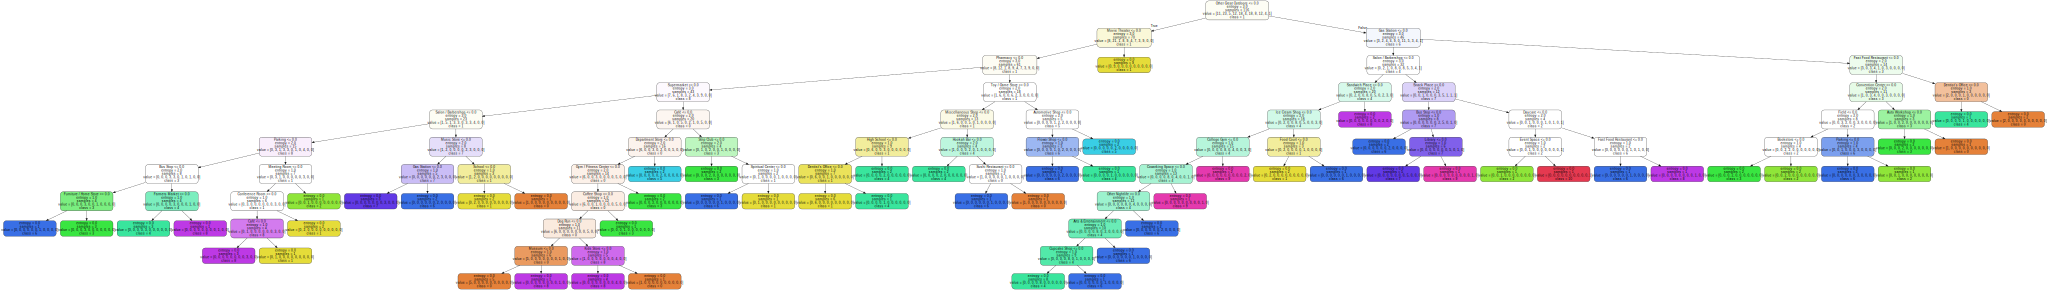

In [381]:
import graphviz 
dot_data = tree.export_graphviz(
    clf, 
    feature_names=X.columns.values,
    class_names=list(map(str,range(max(Y)+1))),
    filled=True, rounded=True, precision=0,
    out_file=None) 
graph = graphviz.Source(dot_data, format='svg')
graph.render(filename='figs/decision')
graph

In [383]:
pd.DataFrame({'Feature': X.columns.values, 'Importance':clf.feature_importances_}).sort_values(by='Importance', ascending=False).head(10)


Feature  Importance
343    Salon / Barbershop    0.084053
185           Gas Station    0.078111
291  Other Great Outdoors    0.070930
271         Movie Theater    0.049378
306              Pharmacy    0.048890
381           Supermarket    0.041040
301               Parking    0.040890
62               Bus Stop    0.039627
67                   Café    0.035084
156  Fast Food Restaurant    0.026635